# Predicción del riesgo de enfermedad cardiaca

El presente proyecto tiene como objetivo desarrollar un modelo de aprendizaje automático que permita predecir el riesgo de enfermedad cardíaca en pacientes, utilizando datos clínicos y de estilo de vida. El proyecto incluirá la integración de datos desde un archivo CSV y una base de datos SQL, el procesamiento y análisis de los datos, la construcción y evaluación de modelos predictivos, y la visualización de los resultados.

## Fuente de datos

### Descripción de los datasets

Heart Disease Dataset (csv): contiene información clínica de pacientes, con atributos relevantes para la predicción de enfermedades cardíacas.
* age (edad)
* sex (género)
* chest pain type (tipo de dolor torácido - 4 valores)
* resting blood pressure (Presión arterial en reposo)
* serum cholestoral in mg/dl (Colesterol sérico en mg/dl)
* fasting blood sugar > 120 mg/dl (Glucemia en ayunas > 120 mg/dl)
* resting electrocardiographic results (Resultados electrocardiográficos en reposo - valores 0, 1 y 2)
* maximum heart rate achieved (Frecuencia cardíaca máxima alcanzada)
* exercise induced angina (Angina inducida por el ejercicio)
* oldpeak = ST depression induced by exercise relative to rest (depresión del segmento ST inducida por el ejercicio en relación con el reposo)
* the slope of the peak exercise ST segment (Pendiente del segmento ST máximo en el ejercicio)
* number of major vessels (0-3) colored by flourosopy (Número de vasos principales (0-3) coloreados por fluorosopía)
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect (0 = normal; 1 = defecto fijo; 2 = defecto reversible)
* Target: 0 = no have heart desease; 1 = have a heart desease

Lifestyle_heart_risk (.db): contiene la tabla lifestyle factors con datos sintéticos de estilo de vida generados de forma sintética con las varíables clínicas del archivo original.
* physical_activity (actividad física) baja | moderada | alta
* smoking_status (fumador) fuma | no fuma
* alcohol_intake (ingiere alcohol) bajo | medio | alto
* diet_quality (calidad de la dieta) pobre | regular | buena

## Análisis exploratorio de datos

In [1]:
#Importación de librerías
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Eetrenamiento de modelo
from sklearn.model_selection import train_test_split

#Escalar los datos
from sklearn.preprocessing import StandardScaler

#Importar modelos y metricas
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Para conectarse a bases de datos SQL
import sqlite3

In [2]:
#Cargar el conjunto de datos csv
df_clinico = pd.read_csv("data/heart.csv")
#Añadir identificador único
df_clinico['patient_id'] = df_clinico.index

In [3]:
#Conectar la base de datos SQLite
conn = sqlite3.connect("data/lifestyle_heart_risk.db")
df_lifestyle = pd.read_sql_query("SELECT * FROM lifestyle_factors", conn)
conn.close()

### Exploración inicial

In [4]:
# Ver las primeras filas (env¿cabezados)
print(df_clinico.head())
print(df_lifestyle.head())



   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  patient_id  
0   2     3       0           0  
1   0     3       0           1  
2   0     3       0           2  
3   1     3       0           3  
4   3     2       0           4  
   patient_id physical_activity smoking_status alcohol_intake diet_quality
0           0          moderada        no fuma           alto        buena
1           1              alta           fuma           bajo        buena
2           2              baja           fuma           bajo      regular
3        

In [5]:
# Dimensiones del dataset
print("Datos clínicos:", df_clinico.shape)
print("Datos estilo de vida:", df_lifestyle.shape)

Datos clínicos: (1025, 15)
Datos estilo de vida: (1025, 5)


In [6]:
# Verificar el ipos de datos
print(df_clinico.dtypes)
print(df_lifestyle.dtypes)

age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca              int64
thal            int64
target          int64
patient_id      int64
dtype: object
patient_id            int64
physical_activity    object
smoking_status       object
alcohol_intake       object
diet_quality         object
dtype: object


In [7]:
#Obtener estadísticas generales
print(df_clinico.describe())
print(df_lifestyle.describe(include='object'))

               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000  

In [8]:
#verificar cuantos hobres y mujeres existen en el dataset
df_clinico.sex.value_counts()

sex
1    713
0    312
Name: count, dtype: int64

## Preprocesamiento de los datos

In [9]:
#Verificar si existen valores nulos
print("Nulos en datos clínicos:")
print(df_clinico.isnull().sum())

print("Nulos en datos estilo de vida:")
print(df_lifestyle.isnull().sum())

Nulos en datos clínicos:
age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
target        0
patient_id    0
dtype: int64
Nulos en datos estilo de vida:
patient_id           0
physical_activity    0
smoking_status       0
alcohol_intake       0
diet_quality         0
dtype: int64


In [10]:
#Codificación de variables categóricas
# Mostrar valores únicos
print(df_lifestyle['physical_activity'].value_counts())
print(df_lifestyle['diet_quality'].value_counts())

# Codificar para el modelo
df_lifestyle_encoded = df_lifestyle.copy()
df_lifestyle_encoded = pd.get_dummies(df_lifestyle_encoded, columns=['physical_activity', 'smoking_status', 'alcohol_intake', 'diet_quality'], drop_first=True)
print(df_lifestyle_encoded.head)

physical_activity
moderada    419
alta        353
baja        253
Name: count, dtype: int64
diet_quality
pobre      424
regular    369
buena      232
Name: count, dtype: int64
<bound method NDFrame.head of       patient_id  physical_activity_baja  physical_activity_moderada  \
0              0                   False                        True   
1              1                   False                       False   
2              2                    True                       False   
3              3                   False                        True   
4              4                    True                       False   
...          ...                     ...                         ...   
1020        1020                   False                       False   
1021        1021                   False                        True   
1022        1022                    True                       False   
1023        1023                   False                       False   
10

## Visualización de datos

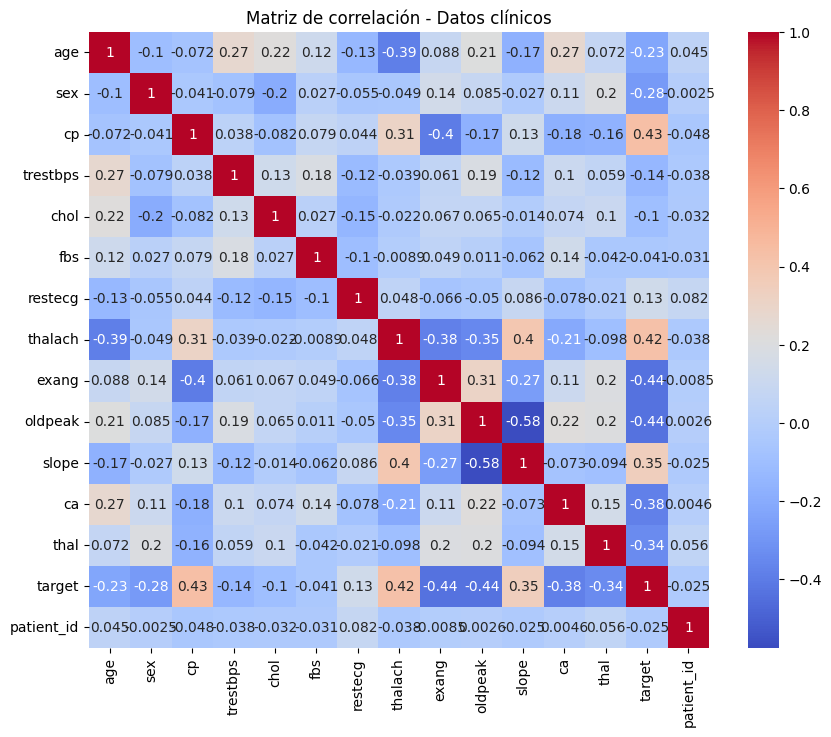

In [11]:
#Correlación de datos clínicos
plt.figure(figsize=(10,8))
sns.heatmap(df_clinico.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación - Datos clínicos")
plt.show()

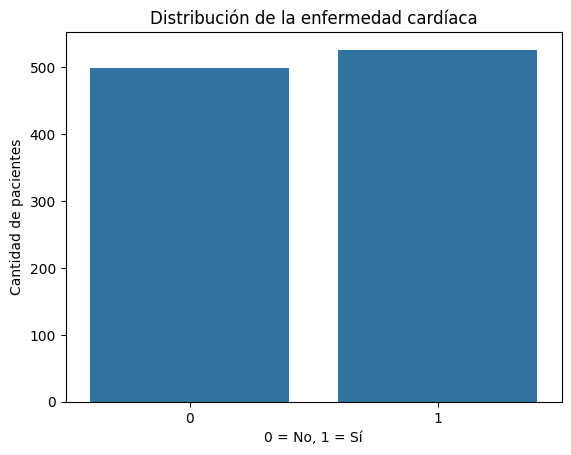

In [12]:
# Distribución de la variable objetivo
sns.countplot(data=df_clinico, x='target')
plt.title("Distribución de la enfermedad cardíaca")
plt.xlabel("0 = No, 1 = Sí")
plt.ylabel("Cantidad de pacientes")
plt.show()

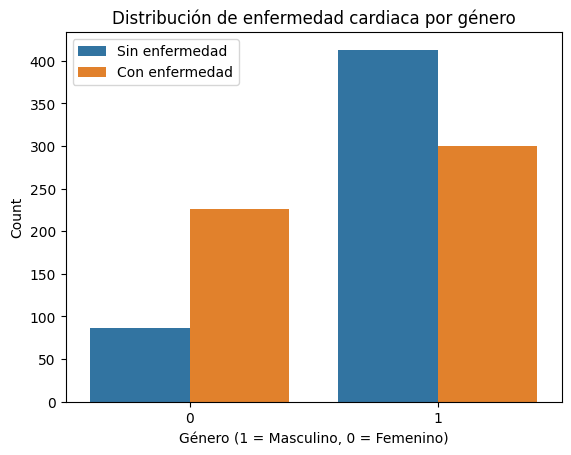

In [13]:
#Distribución de enfermedad cardiaca por género
sns.countplot(x = 'sex', hue = 'target', data = df_clinico)
plt.title('Distribución de enfermedad cardiaca por género')
plt.xlabel('Género (1 = Masculino, 0 = Femenino)')
plt.ylabel('Count')
plt.legend(['Sin enfermedad', 'Con enfermedad'])
plt.show()

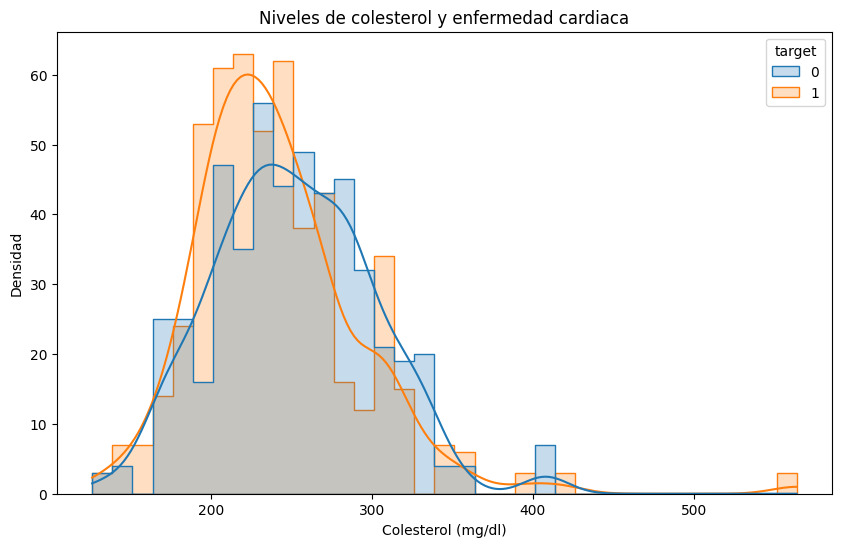

In [14]:
#Distribicíon del colesterol con respecto al estilo de vida
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clinico, x='chol', hue='target', kde=True, element='step')
plt.title('Niveles de colesterol y enfermedad cardiaca')
plt.xlabel('Colesterol (mg/dl)')
plt.ylabel('Densidad')
plt.show()

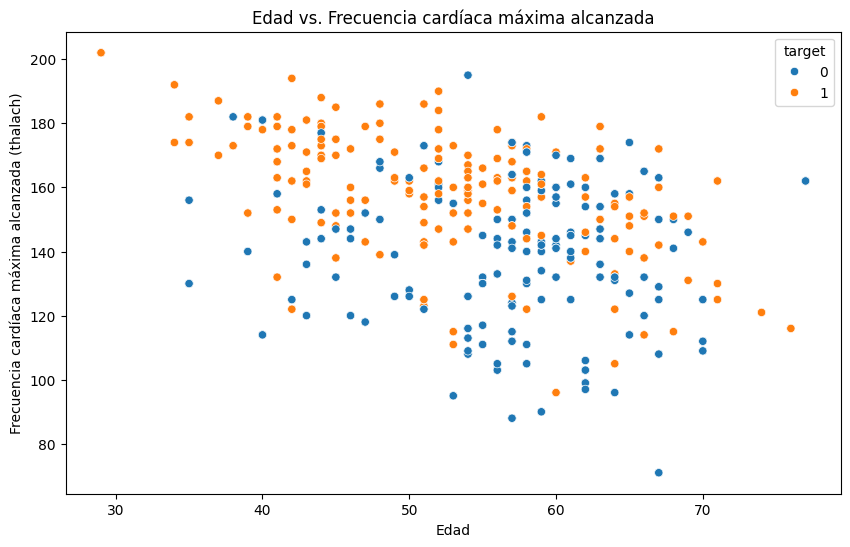

In [15]:
#Edad vs la frecuencia cardíaca máxima
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clinico, x='age', y='thalach', hue='target')
plt.title("Edad vs. Frecuencia cardíaca máxima alcanzada")
plt.xlabel('Edad')
plt.ylabel('Frecuencia cardíaca máxima alcanzada (thalach)')
plt.show()

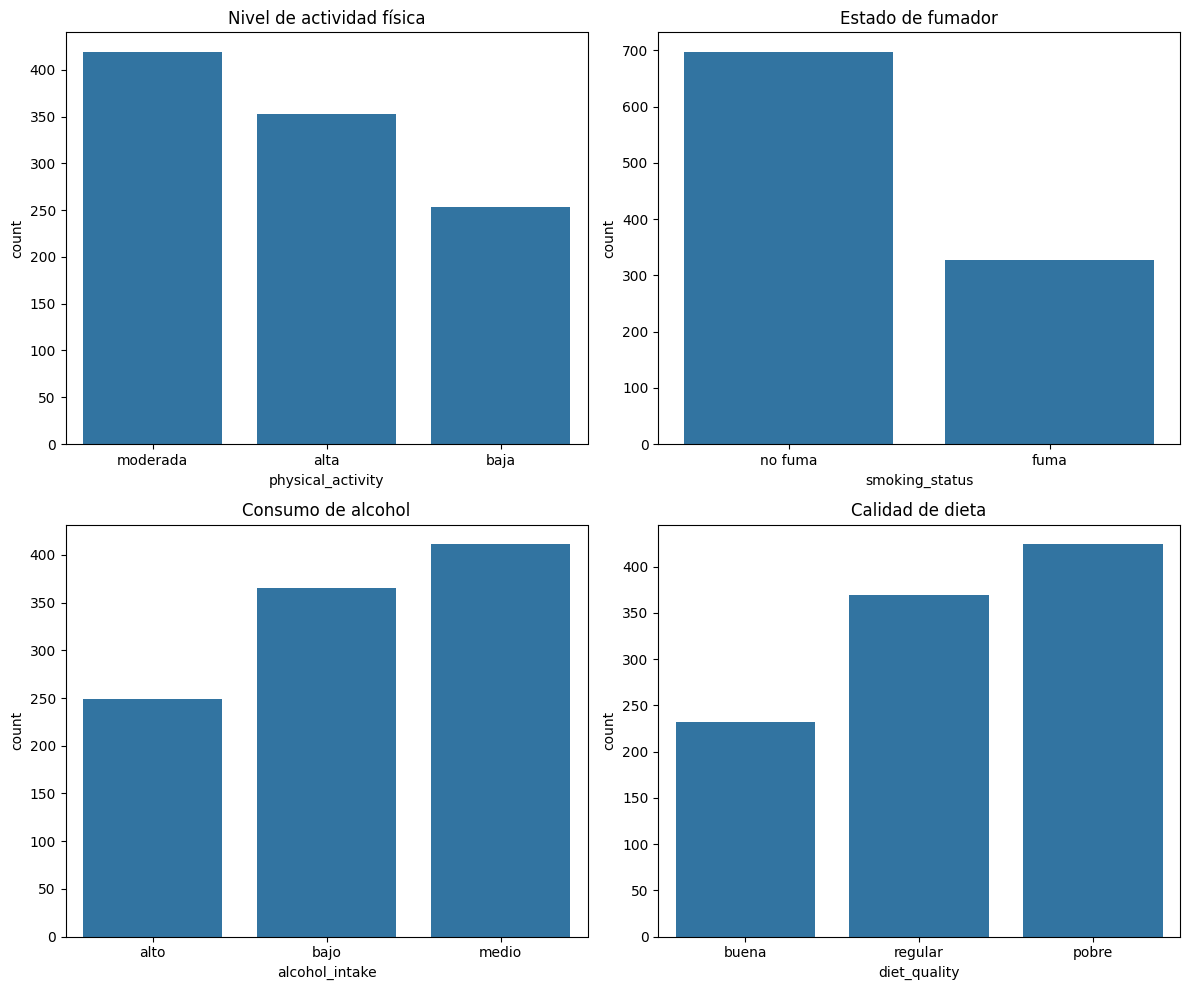

In [16]:
#Comparación del estilo de vida
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(data=df_lifestyle, x='physical_activity', ax=axes[0, 0])
axes[0, 0].set_title("Nivel de actividad física")

sns.countplot(data=df_lifestyle, x='smoking_status', ax=axes[0, 1])
axes[0, 1].set_title("Estado de fumador")

sns.countplot(data=df_lifestyle, x='alcohol_intake', ax=axes[1, 0])
axes[1, 0].set_title("Consumo de alcohol")

sns.countplot(data=df_lifestyle, x='diet_quality', ax=axes[1, 1])
axes[1, 1].set_title("Calidad de dieta")

plt.tight_layout()
plt.show()

# Integración de los datasets

In [17]:
# Asegurarse que ambos datasets tienen el identificador único 'patient_id'
df_clinico['patient_id'] = df_clinico.index  # si no estaba ya
df_lifestyle_encoded['patient_id'] = df_lifestyle_encoded['patient_id'].astype(int)

# Unir por 'patient_id'
df_completo = pd.merge(df_clinico, df_lifestyle_encoded, on='patient_id')

# Verificar dimensiones y columnas
print(df_completo.shape)
print(df_completo.head)


(1025, 22)
<bound method NDFrame.head of       age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      ...  thal  target  patient_i

In [28]:
#Eliminación de la variable objetivo para posterior entrenamiento
# Guardamos la variable objetivo antes de eliminarla del dataset
y = df_completo['target']  # 0 = no enfermedad cardíaca, 1 = sí
X = df_completo.drop(columns=['target', "patient_id"])  # sin la variable objetivo y el identoificador único
print(X.head)

<bound method NDFrame.head of       age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  physical_activity_baja

# Selección y construcción del modelo

In [29]:
# División de los datos en conjuntos de 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
# Estandarización de los datos (necesario para KNN y SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
#Definir los modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Guardar resultados
resultados = {}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    if nombre in ["KNN", "SVM", "Logistic Regression"]:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    resultados[nombre] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }
    
    print(f"\nResultados de {nombre}")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))


Resultados de Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       100
           1       0.79      0.90      0.84       105

    accuracy                           0.82       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.83      0.82      0.82       205

Matriz de Confusión:
 [[74 26]
 [10 95]]

Resultados de KNN
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       100
           1       0.80      0.90      0.85       105

    accuracy                           0.83       205
   macro avg       0.84      0.83      0.83       205
weighted avg       0.84      0.83      0.83       205

Matriz de Confusión:
 [[76 24]
 [10 95]]

Resultados de SVM
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       100
           1       0.85      0.92      0.89       105

    accuracy               

# Análisis de resultados


Comparación de modelos:

                     Accuracy  Precision    Recall  F1 Score
Random Forest        0.995122   1.000000  0.990476  0.995215
Decision Tree        0.985366   1.000000  0.971429  0.985507
SVM                  0.878049   0.850877  0.923810  0.885845
KNN                  0.834146   0.798319  0.904762  0.848214
Logistic Regression  0.824390   0.785124  0.904762  0.840708


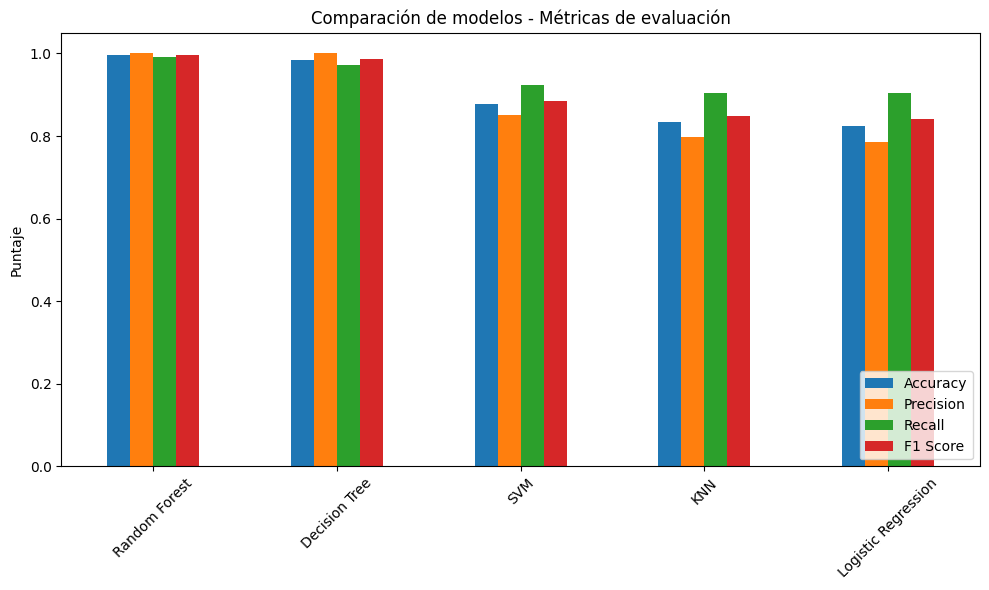

In [32]:
# Convertimos resultados a DataFrame para visualización
df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.sort_values(by="F1 Score", ascending=False)

# Mostrar tabla comparativa
print("\nComparación de modelos:\n")
print(df_resultados)

# Gráfica comparativa
df_resultados.plot(kind="bar", figsize=(10, 6))
plt.title("Comparación de modelos - Métricas de evaluación")
plt.ylabel("Puntaje")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Random Forest
Utilizaremos el modelo RF debido a que es el que mejor puntuación alcanzó en las métricas

In [33]:
#Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

In [34]:
# Configurar la conexión con el servidor MLflow en el puerto 9090
mlflow.set_tracking_uri("http://localhost:9090")

# Crear o seleccionar el experimento
mlflow.set_experiment("Heart Disease Prediction")

<Experiment: artifact_location='mlflow-artifacts:/4', creation_time=1748227352439, experiment_id='4', last_update_time=1748227352439, lifecycle_stage='active', name='Heart Disease Prediction', tags={}>

In [35]:
# Entrenar el modelo Random Forest y registrar con MLflow
with mlflow.start_run(run_name="RandomForest-HeartModel"):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)  # Usa los datos NO escalados para RandomForest

    # Predicción y métricas
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Registrar métricas y parámetros
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("model_type", "RandomForestClassifier")

    # Guardar y publicar el modelo en MLflow
    mlflow.sklearn.log_model(rf, "random_forest_model")

    print("Modelo registrado y métricas almacenadas en MLflow.")

2025/05/25 22:18:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo registrado y métricas almacenadas en MLflow.
🏃 View run RandomForest-HeartModel at: http://localhost:9090/#/experiments/4/runs/b6475618ea4646469ecd5b8a0c8b5759
🧪 View experiment at: http://localhost:9090/#/experiments/4


In [36]:
print(X.columns.tolist())

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'physical_activity_baja', 'physical_activity_moderada', 'smoking_status_no fuma', 'alcohol_intake_bajo', 'alcohol_intake_medio', 'diet_quality_pobre', 'diet_quality_regular']
